In [11]:
!kaggle datasets download -d kiva/data-science-for-good-kiva-crowdfunding --unzip

Dataset URL: https://www.kaggle.com/datasets/kiva/data-science-for-good-kiva-crowdfunding
License(s): CC0-1.0




  0%|          | 0.00/41.9M [00:00<?, ?B/s]
  2%|▏         | 1.00M/41.9M [00:00<00:29, 1.45MB/s]
  5%|▍         | 2.00M/41.9M [00:00<00:14, 2.91MB/s]
 10%|▉         | 4.00M/41.9M [00:00<00:06, 6.26MB/s]
 19%|█▉        | 8.00M/41.9M [00:01<00:02, 13.1MB/s]
 29%|██▊       | 12.0M/41.9M [00:01<00:01, 18.6MB/s]
 38%|███▊      | 16.0M/41.9M [00:01<00:01, 23.0MB/s]
 48%|████▊     | 20.0M/41.9M [00:01<00:00, 26.2MB/s]
 57%|█████▋    | 24.0M/41.9M [00:01<00:00, 28.4MB/s]
 67%|██████▋   | 28.0M/41.9M [00:01<00:00, 30.2MB/s]
 76%|███████▋  | 32.0M/41.9M [00:01<00:00, 31.4MB/s]
 86%|████████▌ | 36.0M/41.9M [00:01<00:00, 32.3MB/s]
 96%|█████████▌| 40.0M/41.9M [00:02<00:00, 32.9MB/s]
100%|██████████| 41.9M/41.9M [00:02<00:00, 21.0MB/s]


## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import shap
import joblib
from scipy.sparse import hstack


c:\Users\Esben\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparation and Preprocessing

In [2]:
df_new = pd.read_csv('kiva_loans.csv')

In [3]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  671205 non-null  int64  
 1   funded_amount       671205 non-null  float64
 2   loan_amount         671205 non-null  float64
 3   activity            671205 non-null  object 
 4   sector              671205 non-null  object 
 5   use                 666973 non-null  object 
 6   country_code        671197 non-null  object 
 7   country             671205 non-null  object 
 8   region              614405 non-null  object 
 9   currency            671205 non-null  object 
 10  partner_id          657698 non-null  float64
 11  posted_time         671205 non-null  object 
 12  disbursed_time      668809 non-null  object 
 13  funded_time         622874 non-null  object 
 14  term_in_months      671205 non-null  float64
 15  lender_count        671205 non-nul

In [4]:
df_new.isnull().sum()

id                         0
funded_amount              0
loan_amount                0
activity                   0
sector                     0
use                     4232
country_code               8
country                    0
region                 56800
currency                   0
partner_id             13507
posted_time                0
disbursed_time          2396
funded_time            48331
term_in_months             0
lender_count               0
tags                  171416
borrower_genders        4221
repayment_interval         0
date                       0
dtype: int64

In [5]:
df_new.drop(columns=['use', 'tags'], inplace=True)
df_new.dropna(subset=['region', 'partner_id', 'disbursed_time', 'funded_time', 'borrower_genders' ], inplace=True)

In [6]:
df_new.duplicated().sum()

0

In [7]:
date_cols = ['posted_time', 'disbursed_time', 'funded_time', 'date']
df_new[date_cols] = df_new[date_cols].apply(pd.to_datetime, errors='coerce')

In [8]:
# Define the function
def gender_group(row):
    if row['borrower_genders'] == 'male':
        return 'male'
    elif row['borrower_genders'] == 'female':
        return 'female'
    else:
        return 'group'

# Apply the function and overwrite the 'borrower_genders' column
df_new['borrower_genders'] = df_new.apply(gender_group, axis=1)


In [9]:
df_new.describe()

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count,date
count,5.741270e+05,574127.000000,574127.000000,574127.000000,574127.000000,574127.000000,574127
mean,9.927999e+05,758.391567,758.391567,180.249194,13.438011,20.112515,2015-11-17 18:00:44.657716224
min,6.530470e+05,25.000000,25.000000,9.000000,2.000000,1.000000,2014-01-01 00:00:00
25%,8.227815e+05,250.000000,250.000000,127.000000,8.000000,7.000000,2014-12-31 00:00:00
50%,9.917490e+05,450.000000,450.000000,145.000000,12.000000,13.000000,2015-12-08 00:00:00
75%,1.167732e+06,900.000000,900.000000,204.000000,14.000000,24.000000,2016-10-14 00:00:00
max,1.340300e+06,100000.000000,100000.000000,535.000000,158.000000,2986.000000,2017-07-24 00:00:00
std,1.971428e+05,1051.554879,1051.554879,94.988259,8.581805,27.716397,NaN


In [10]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 574127 entries, 0 to 671186
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   id                  574127 non-null  int64              
 1   funded_amount       574127 non-null  float64            
 2   loan_amount         574127 non-null  float64            
 3   activity            574127 non-null  object             
 4   sector              574127 non-null  object             
 5   country_code        574119 non-null  object             
 6   country             574127 non-null  object             
 7   region              574127 non-null  object             
 8   currency            574127 non-null  object             
 9   partner_id          574127 non-null  float64            
 10  posted_time         574127 non-null  datetime64[ns, UTC]
 11  disbursed_time      574127 non-null  datetime64[ns, UTC]
 12  funded_time         5

In [11]:
df_new['funding_days'] = (df_new['funded_time'] - df_new['posted_time']).dt.days

In [12]:
columns = ['funded_amount', 'loan_amount', 'sector', 'country', 'funding_days',
           'term_in_months', 'lender_count', 'borrower_genders', 'repayment_interval']

df_final = df_new[columns]

df_final.head()

,funded_amount,loan_amount,sector,country,funding_days,term_in_months,lender_count,borrower_genders,repayment_interval
0,300.0,300.0,Food,Pakistan,1,12.0,12,female,irregular
1,575.0,575.0,Transportation,Pakistan,1,11.0,14,group,irregular
2,150.0,150.0,Transportation,India,0,43.0,6,female,bullet
3,200.0,200.0,Arts,Pakistan,0,11.0,8,female,irregular
4,400.0,400.0,Food,Pakistan,0,14.0,16,female,monthly


In [13]:
import pandas as pd

# Assuming df_new is your original DataFrame

# Example: If you want to filter by the number of loans
top_countries = df_final['country'].value_counts().nlargest(5).index.tolist()

# Filter the DataFrame based on the top 5 countries
df_final = df_final[df_final['country'].isin(top_countries)]

# Display the filtered DataFrame's shape and some samples
print("Filtered DataFrame shape:", df_final.shape)
print(df_final.head())


Filtered DataFrame shape: (299200, 9)
   funded_amount  loan_amount          sector   country  funding_days  \
0          300.0        300.0            Food  Pakistan             1   
1          575.0        575.0  Transportation  Pakistan             1   
3          200.0        200.0            Arts  Pakistan             0   
4          400.0        400.0            Food  Pakistan             0   
7          400.0        400.0        Services  Pakistan             9   

   term_in_months  lender_count borrower_genders repayment_interval  
0            12.0            12           female          irregular  
1            11.0            14            group          irregular  
3            11.0             8           female          irregular  
4            14.0            16           female            monthly  
7            14.0             8           female            monthly  


In [14]:
df_final

,funded_amount,loan_amount,sector,country,funding_days,term_in_months,lender_count,borrower_genders,repayment_interval
0,300.0,300.0,Food,Pakistan,1,12.0,12,female,irregular
1,575.0,575.0,Transportation,Pakistan,1,11.0,14,group,irregular
3,200.0,200.0,Arts,Pakistan,0,11.0,8,female,irregular
4,400.0,400.0,Food,Pakistan,0,14.0,16,female,monthly
7,400.0,400.0,Services,Pakistan,9,14.0,8,female,monthly
...,...,...,...,...,...,...,...,...,...
670727,475.0,475.0,Housing,Peru,4,14.0,17,female,monthly
670732,625.0,625.0,Agriculture,Peru,1,20.0,21,female,monthly
671152,25.0,25.0,Agriculture,Pakistan,1,13.0,1,female,monthly
671164,25.0,25.0,Agriculture,Pakistan,0,13.0,1,female,monthly


In [15]:
# Remove outliers
df_final['funding_days_z'] = (df_final['funding_days'] - df_final['funding_days'].mean()) / df_final['funding_days'].std(ddof=0)
df_final = df_final[df_final.funding_days_z.abs() < 2]

print("Data shape after initial filtering:", df_final.shape)

Data shape after initial filtering: (281269, 10)


In [16]:
# Separate features and target
X = df_final.drop('funding_days', axis=1)  # All features except 'funding_days'
y = df_final['funding_days']  # Target variable

# Identify categorical and numerical features
cat_features = ['sector', 'country', 'borrower_genders', 'repayment_interval']
num_features = ['funded_amount', 'loan_amount', 'term_in_months', 'lender_count']

# One-hot encode categorical variables with sparse output to save memory
ohe = OneHotEncoder()  # Use sparse_output=True to reduce memory usage
X_cat = pd.DataFrame(ohe.fit_transform(X[cat_features]).todense(), columns=ohe.get_feature_names_out(cat_features))

# Scale numerical features
scaler = StandardScaler()
X_num = pd.DataFrame(scaler.fit_transform(X[num_features]), columns=num_features)


# Convert numerical features to sparse matrix and combine with categorical features
X_processed = pd.concat([X_num, X_cat], axis=1)


print("Shape of processed features:", X_processed.shape)


Shape of processed features: (281269, 30)


In [17]:
X_processed

,funded_amount,loan_amount,term_in_months,lender_count,sector_Agriculture,sector_Arts,sector_Clothing,sector_Construction,sector_Education,sector_Entertainment,...,country_Kenya,country_Pakistan,country_Peru,country_Philippines,borrower_genders_female,borrower_genders_group,borrower_genders_male,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly
0,-0.254350,-0.254350,0.129045,0.016326,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.179683,0.179683,-0.022029,0.144107,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.412181,-0.412181,-0.022029,-0.239236,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.096520,-0.096520,0.431192,0.271888,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.096520,-0.096520,0.431192,-0.239236,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281264,0.021853,0.021853,0.431192,0.335778,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
281265,0.258598,0.258598,1.337634,0.591340,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
281266,-0.688384,-0.688384,0.280119,-0.686468,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
281267,-0.688384,-0.688384,0.280119,-0.686468,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [18]:

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Train XGBoost model
model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, model_xgb.predict(X_test)))

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

Train RMSE: 6.81
Test RMSE: 6.91


In [19]:
model_xgb.score(X_test, y_test)

0.38696062564849854

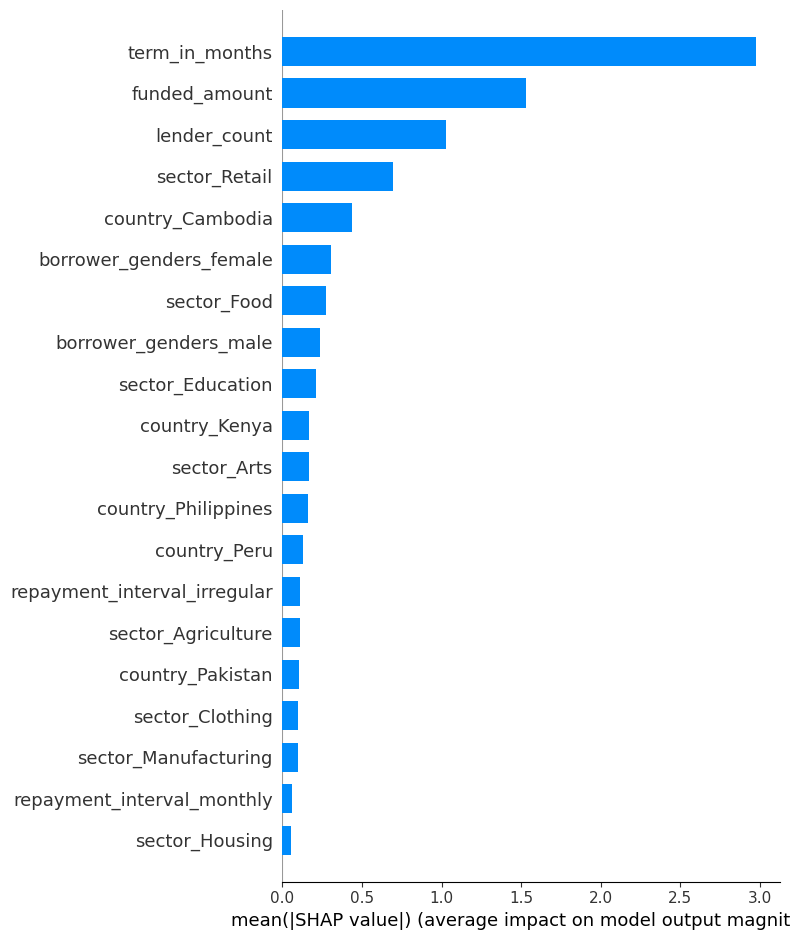

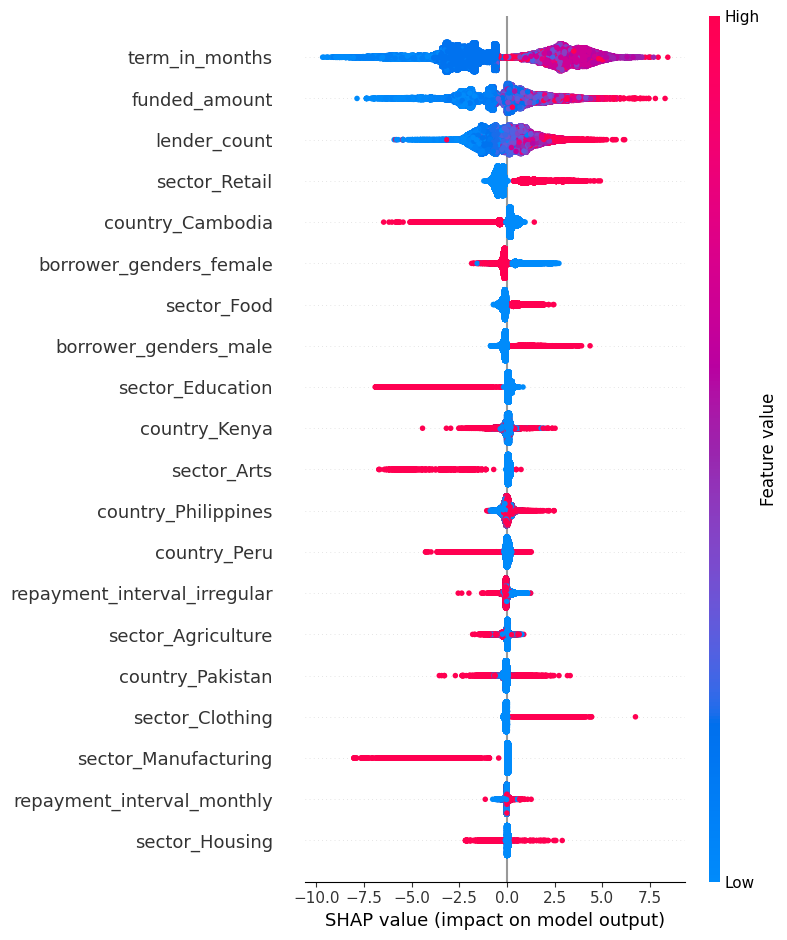

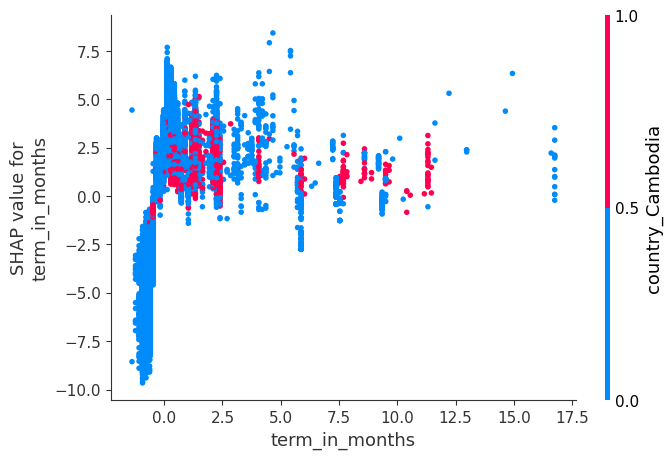

In [20]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(model_xgb)

# Get SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot feature importances
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Plot SHAP values
shap.summary_plot(shap_values, X_test)


# Find the most important feature
most_important_feature_index = np.argmax(np.abs(shap_values).mean(0))
most_important_feature = X_test.columns[most_important_feature_index]  # Get the feature name

# Plot dependence for the most important feature
shap.dependence_plot(most_important_feature, shap_values, X_test)  # Use dense matrix here


In [21]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [22]:
joblib.dump(model_xgb, 'model_xgb1.joblib')
joblib.dump(scaler, 'scaler1.joblib')
joblib.dump(ohe, 'ohe1.joblib')

['ohe1.joblib']

In [28]:
expected_feature_names = ohe.get_feature_names_out()
expected_feature_names


array(['sector_Agriculture', 'sector_Arts', 'sector_Clothing',
       'sector_Construction', 'sector_Education', 'sector_Entertainment',
       'sector_Food', 'sector_Health', 'sector_Housing',
       'sector_Manufacturing', 'sector_Personal Use', 'sector_Retail',
       'sector_Services', 'sector_Transportation', 'sector_Wholesale',
       'country_Cambodia', 'country_Kenya', 'country_Pakistan',
       'country_Peru', 'country_Philippines', 'borrower_genders_female',
       'borrower_genders_group', 'borrower_genders_male',
       'repayment_interval_bullet', 'repayment_interval_irregular',
       'repayment_interval_monthly'], dtype=object)